In [61]:
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi
from dotenv import load_dotenv
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro, anderson, kstest, normaltest
from scipy.signal import savgol_filter
from sklearn.neighbors import KernelDensity
import streamlit as st
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer
import scikit_posthocs as sp
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from tabulate import tabulate
from scipy.stats import chi2
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from pingouin import multivariate_normality
from pygam import LogisticGAM, s, f
from imblearn.over_sampling import ADASYN
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, train_test_split


import networkx as nx
from community import community_louvain
import numpy as np

## Helper functions
from helper_functions import find_best_hyperparameters, permutation_test_logistic, mahalanobis_distance,fit_and_predict,  cool_plotting, bootstrap_ci, kde_density, plot_confusion_matrix, calculateClasswiseTopNAccuracy, calculateMetrics, calculateMetricsAndPrint
################################## You can change values inside the following list ###########################
topNValues = [10,20,30,40,50,60,70,80,90]
##############################################################################################################


## Env

In [3]:
load_dotenv()
os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")
api = KaggleApi()
api.authenticate()
dataset_name = "fedesoriano/stroke-prediction-dataset"
api.dataset_download_files(dataset_name, path=os.getcwd(), unzip=True)

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset


In [4]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

## EDA

In [5]:
print(df.isna().sum())
df.dropna(inplace = True)
df = df[df.gender !="Other"]
df.reset_index(inplace = True,drop=True)

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


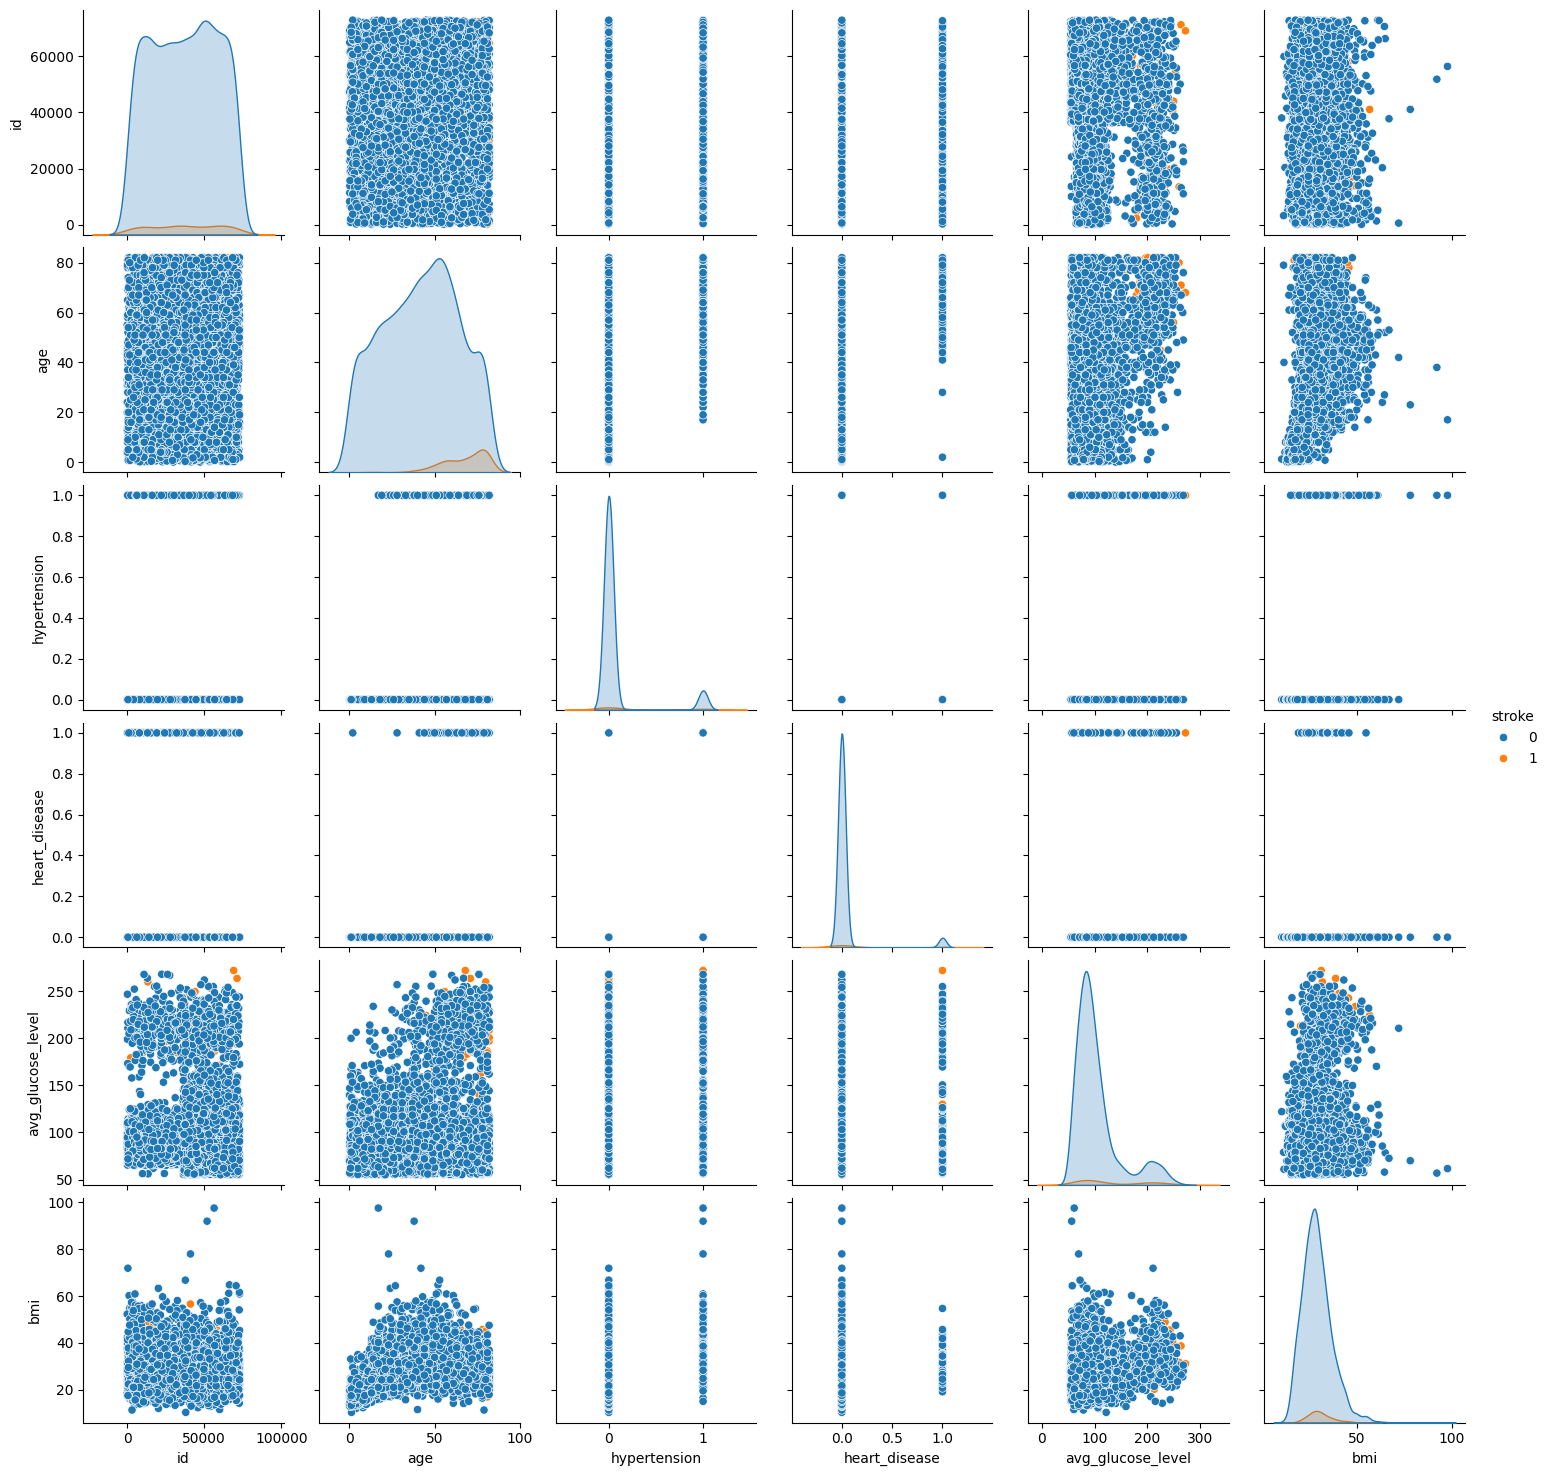

In [6]:
sns.pairplot(df, hue="stroke")
plt.show()

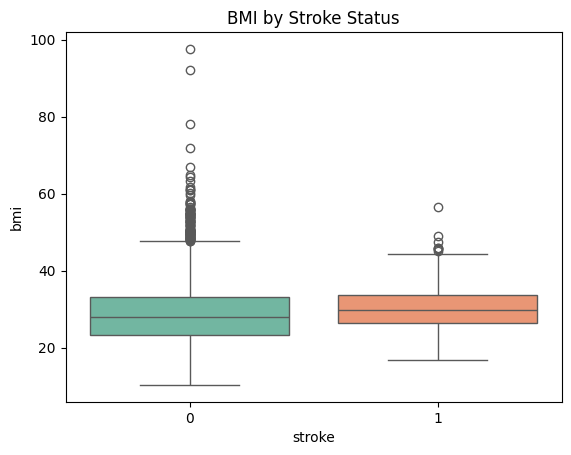

In [7]:
sns.boxplot(data=df, x="stroke", y="bmi", palette="Set2",legend=False, hue = "stroke")
plt.title("BMI by Stroke Status")
plt.show()

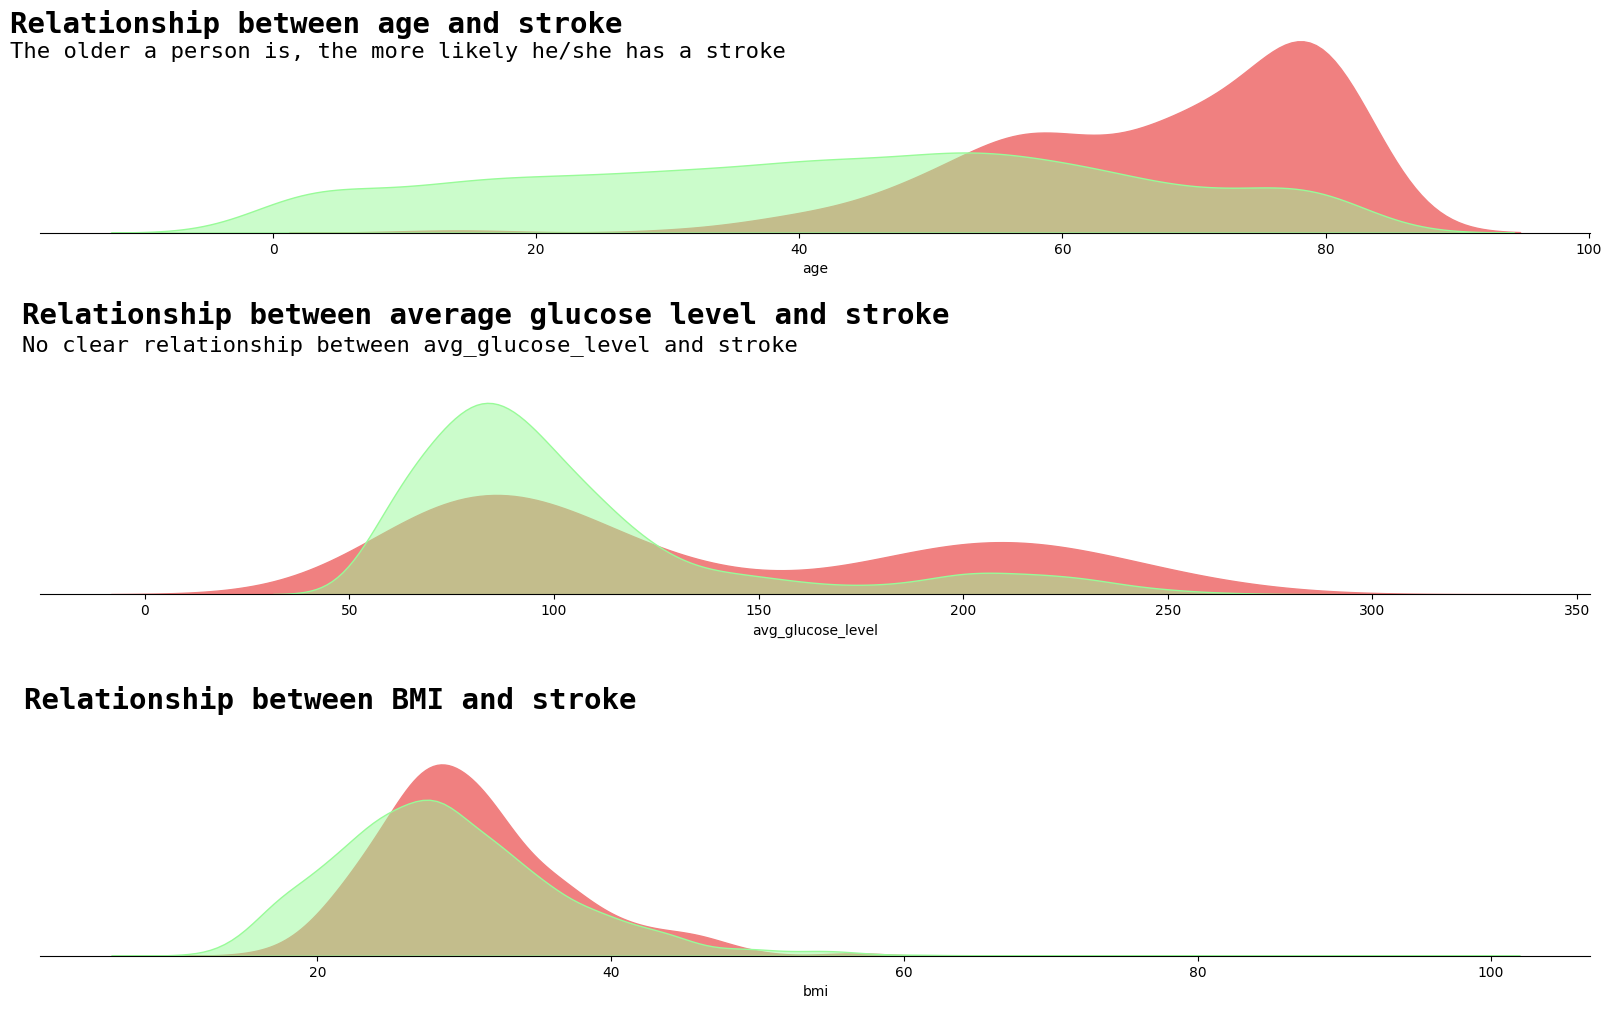

In [10]:
fig = plt.figure(figsize=(20, 12), facecolor='white')
ax = [None for _ in range(3)]
gs = fig.add_gridspec(3, 1)
gs.update(wspace=0, hspace=0.8)

# Titles and text
ax[0] = fig.add_subplot(gs[0, 0])
ax[1] = fig.add_subplot(gs[1, 0])
ax[2] = fig.add_subplot(gs[2, 0])

# Relationship between age and stroke
ax[0].text(-20, 0.04, 'Relationship between age and stroke', fontsize=21, fontweight='bold', fontfamily='monospace')
ax[0].text(-20, 0.035, 'The older a person is, the more likely he/she has a stroke', fontsize=16, fontweight='light', fontfamily='monospace')

# Relationship between average glucose level and stroke
ax[1].text(-30, 0.023, 'Relationship between average glucose level and stroke', fontsize=21, fontweight='bold', fontfamily='monospace')
ax[1].text(-30, 0.0207, 'No clear relationship between avg_glucose_level and stroke', fontsize=16, fontweight='light', fontfamily='monospace')

# Relationship between BMI and stroke
ax[2].text(0, 0.09053, 'Relationship between BMI and stroke', fontsize=21, fontweight='bold', fontfamily='monospace')

# Plot KDE for stroke=1 (red) and stroke=0 (green) for age
sns.kdeplot(data=df[df.stroke == 1], x='age', ax=ax[0], fill=True, color='lightcoral', alpha=1)
sns.kdeplot(data=df[df.stroke == 0], x='age', ax=ax[0], fill=True, color='palegreen', alpha=0.5)

# Plot KDE for stroke=1 (red) and stroke=0 (green) for avg_glucose_level
sns.kdeplot(data=df[df.stroke == 1], x='avg_glucose_level', ax=ax[1], fill=True, color='lightcoral', alpha=1)
sns.kdeplot(data=df[df.stroke == 0], x='avg_glucose_level', ax=ax[1], fill=True, color='palegreen', alpha=0.5)

# Plot KDE for stroke=1 (red) and stroke=0 (green) for BMI
sns.kdeplot(data=df[df.stroke == 1], x='bmi', ax=ax[2], fill=True, color='lightcoral', alpha=1)
sns.kdeplot(data=df[df.stroke == 0], x='bmi', ax=ax[2], fill=True, color='palegreen', alpha=0.5)

for i in range(3):
    ax[i].set_yticklabels('')
    ax[i].set_ylabel('')
    ax[i].tick_params(axis='y', length=0)
    for direction in ['top', 'right', 'left']:
        ax[i].spines[direction].set_visible(False)

plt.show()

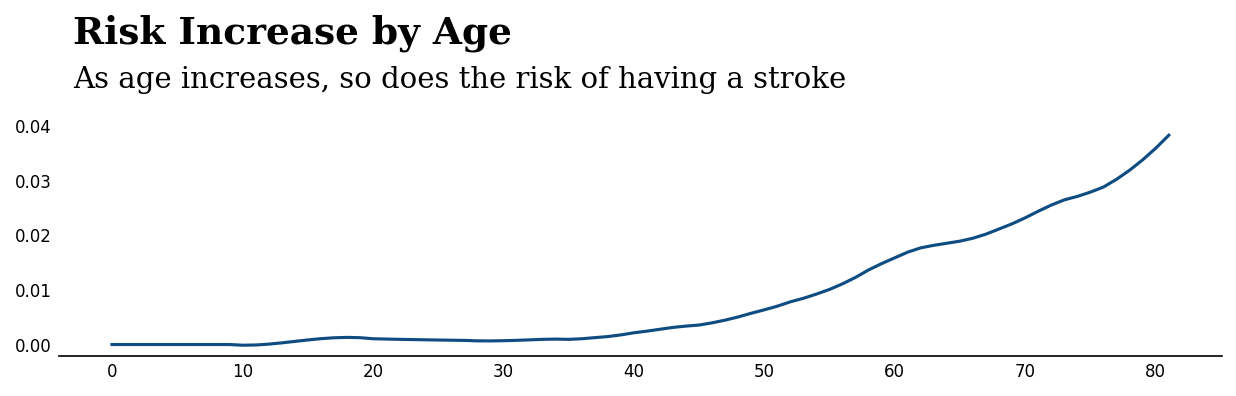

In [11]:
fig = plt.figure(figsize=(10, 5), dpi=150, facecolor='white')
gs = fig.add_gridspec(2, 1)
gs.update(wspace=0.11, hspace=0.5)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor('white')

df['age'] = df['age'].astype(int)

# Calculate risk rate by age
rate = []
for i in range(df['age'].min(), df['age'].max()):
    subset = df[df['age'] < i]
    if len(subset) > 0:  # Avoid division by zero
        rate.append(subset['stroke'].sum() / len(subset['stroke']))
    else:
        rate.append(0)  # Assign 0 risk if no data points exist

# Apply Savitzky-Golay filter to smooth the rate curve
smoothed_rate = savgol_filter(rate, window_length=11, polyorder=2)
sns.lineplot(data=smoothed_rate, color='#0f4c81', ax=ax0)
for s in ["top", "right", "left"]:
    ax0.spines[s].set_visible(False)

ax0.tick_params(axis='both', which='major', labelsize=8)
ax0.tick_params(axis=u'both', which=u'both', length=0)
ax0.text(-3, 0.055, 'Risk Increase by Age', fontsize=18, fontfamily='serif', fontweight='bold')
ax0.text(-3, 0.047, 'As age increases, so does the risk of having a stroke', fontsize=14, fontfamily='serif')
plt.show()

## Statistical Testing

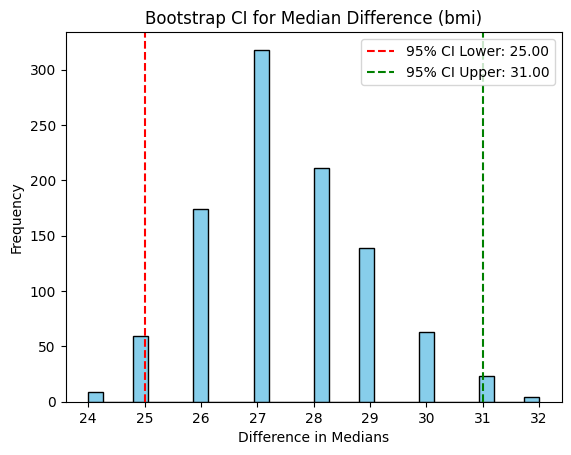

In [12]:
differences, ci_lower, ci_upper = bootstrap_ci(df, "stroke", "age", group1=1, group2=0,stat_fn=np.median, n_iterations=1000, alpha=0.05)
plt.hist(differences, bins=30, color="skyblue", edgecolor="black")
plt.axvline(ci_lower, color="red", linestyle="--", label=f"95% CI Lower: {ci_lower:.2f}")
plt.axvline(ci_upper, color="green", linestyle="--", label=f"95% CI Upper: {ci_upper:.2f}")
plt.title("Bootstrap CI for Median Difference (bmi)")
plt.xlabel("Difference in Medians")
plt.ylabel("Frequency")
plt.legend()
plt.show()

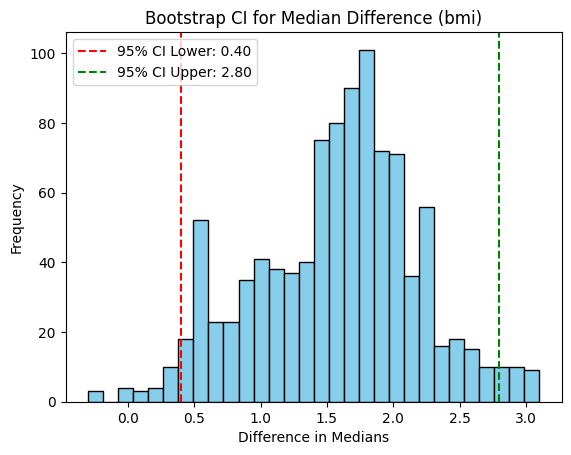

In [13]:
differences, ci_lower, ci_upper = bootstrap_ci(df, "stroke", "bmi", group1=1, group2=0,stat_fn=np.median, n_iterations=1000, alpha=0.05)
plt.hist(differences, bins=30, color="skyblue", edgecolor="black")
plt.axvline(ci_lower, color="red", linestyle="--", label=f"95% CI Lower: {ci_lower:.2f}")
plt.axvline(ci_upper, color="green", linestyle="--", label=f"95% CI Upper: {ci_upper:.2f}")
plt.title("Bootstrap CI for Median Difference (bmi)")
plt.xlabel("Difference in Medians")
plt.ylabel("Frequency")
plt.legend()
plt.show()

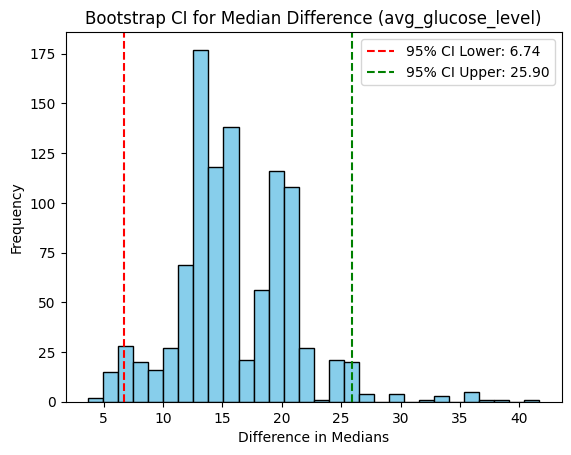

In [14]:
## BOOTSTRAP CI
differences, ci_lower, ci_upper = bootstrap_ci(df, "stroke", "avg_glucose_level", group1=1, group2=0,stat_fn=np.median, n_iterations=1000, alpha=0.05)
plt.hist(differences, bins=30, color="skyblue", edgecolor="black")
plt.axvline(ci_lower, color="red", linestyle="--", label=f"95% CI Lower: {ci_lower:.2f}")
plt.axvline(ci_upper, color="green", linestyle="--", label=f"95% CI Upper: {ci_upper:.2f}")
plt.title("Bootstrap CI for Median Difference (avg_glucose_level)")
plt.xlabel("Difference in Medians")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Proving need for nonparametric methods:
lets prove that whatever we do we cant make them normal --> we will have to use some form of nonparam approach
!! logistic regression doe snot assume notmality

In [15]:
scaler = PowerTransformer(method='yeo-johnson', standardize=False, copy=True)

In [16]:
# numerical features
numerical_cols = ['age', 'avg_glucose_level', 'bmi']
data = df[numerical_cols].dropna()

In [17]:
data_scaled_1 = scaler.fit_transform(data)

In [18]:
alpha = 0.05
num_tests = len(numerical_cols) * 4  # 3 features * 4 tests per feature
adjusted_alpha = alpha / num_tests  # Bonferroni correction

scalers = {"PowerTransformer_YeoJohnson": data_scaled_1}

for scaler_name, scaled_data in scalers.items():
    print(f"=== Testing Normality for {scaler_name} ===")
    for i, col in enumerate(numerical_cols):
        print(f"\nFeature: {col}")

        # Shapiro-Wilk Test
        stat, p = shapiro(scaled_data[:, i])
        print(f"Shapiro-Wilk: W={stat:.4f}, p={p:.4f} (Bonferroni adj: {adjusted_alpha:.5f}) {'REJECT' if p < adjusted_alpha else 'FAIL TO REJECT'}")

        # Kolmogorov-Smirnov Test
        stat, p = kstest(scaled_data[:, i], 'norm')
        print(f"Kolmogorov-Smirnov: D={stat:.4f}, p={p:.4f} (Bonferroni adj: {adjusted_alpha:.5f}) {'REJECT' if p < adjusted_alpha else 'FAIL TO REJECT'}")

        # Anderson-Darling Test
        ad_test = anderson(scaled_data[:, i], dist='norm')
        print(f"Anderson-Darling: A^2={ad_test.statistic:.4f}, Critical Values={ad_test.critical_values}")

        # D'Agostino & Pearson Test
        stat, p = normaltest(scaled_data[:, i])
        print(f"D'Agostino & Pearson: K^2={stat:.4f}, p={p:.4f} (Bonferroni adj: {adjusted_alpha:.5f}) {'REJECT' if p < adjusted_alpha else 'FAIL TO REJECT'}")

    # Multivariate Normality Test
    print(f"\n=== Multivariate Normality Test for {scaler_name} ===")
    mardia_test = multivariate_normality(pd.DataFrame(scaled_data, columns=numerical_cols), alpha=adjusted_alpha)
    print(mardia_test)


=== Testing Normality for PowerTransformer_YeoJohnson ===

Feature: age
Shapiro-Wilk: W=0.9667, p=0.0000 (Bonferroni adj: 0.00417) REJECT
Kolmogorov-Smirnov: D=0.9614, p=0.0000 (Bonferroni adj: 0.00417) REJECT
Anderson-Darling: A^2=35.7757, Critical Values=[0.576 0.655 0.786 0.917 1.091]
D'Agostino & Pearson: K^2=642.5291, p=0.0000 (Bonferroni adj: 0.00417) REJECT

Feature: avg_glucose_level
Shapiro-Wilk: W=0.9829, p=0.0000 (Bonferroni adj: 0.00417) REJECT
Kolmogorov-Smirnov: D=0.8207, p=0.0000 (Bonferroni adj: 0.00417) REJECT
Anderson-Darling: A^2=14.7962, Critical Values=[0.576 0.655 0.786 0.917 1.091]
D'Agostino & Pearson: K^2=86.6995, p=0.0000 (Bonferroni adj: 0.00417) REJECT

Feature: bmi
Shapiro-Wilk: W=0.9982, p=0.0000 (Bonferroni adj: 0.00417) REJECT
Kolmogorov-Smirnov: D=0.9928, p=0.0000 (Bonferroni adj: 0.00417) REJECT
Anderson-Darling: A^2=2.4938, Critical Values=[0.576 0.655 0.786 0.917 1.091]
D'Agostino & Pearson: K^2=8.7221, p=0.0128 (Bonferroni adj: 0.00417) FAIL TO REJE

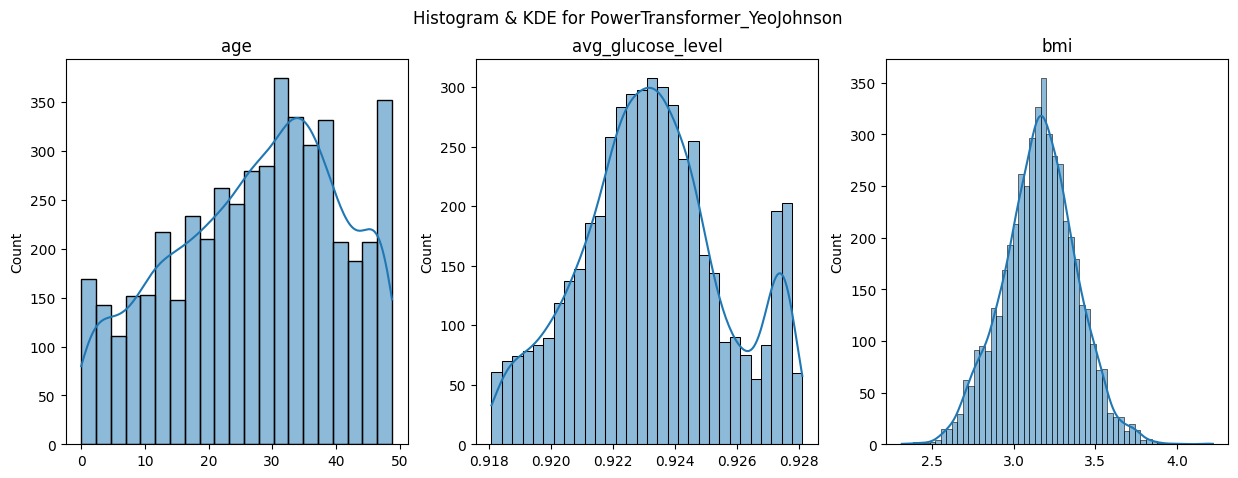

In [19]:
for scaler_name, scaled_data in scalers.items():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Histogram & KDE for {scaler_name}")
    for i, col in enumerate(numerical_cols):
        sns.histplot(scaled_data[:, i], kde=True, ax=axes[i])
        axes[i].set_title(f"{col}")
    plt.show()

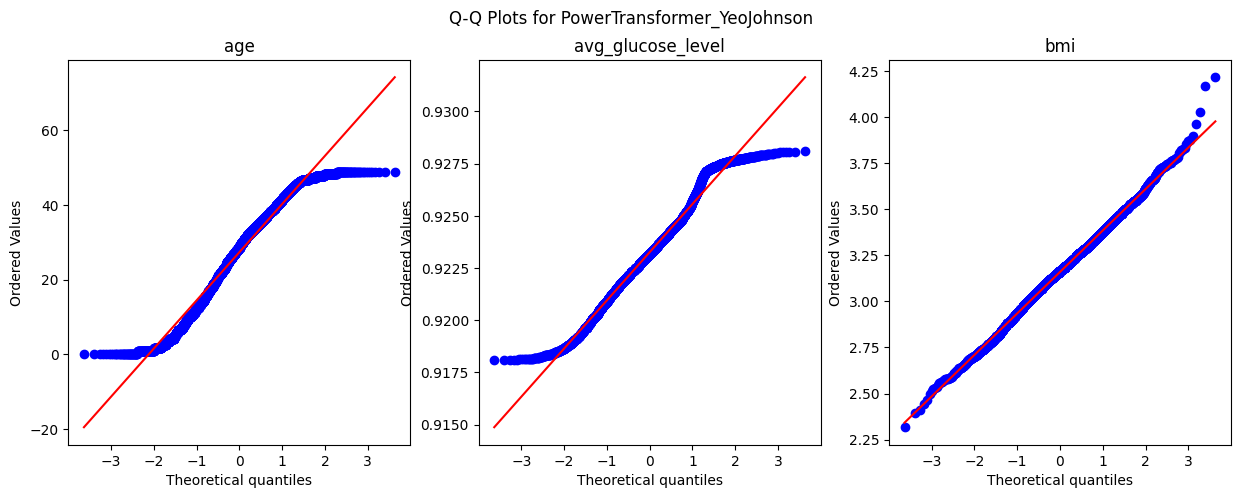

In [20]:
for scaler_name, scaled_data in scalers.items():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Q-Q Plots for {scaler_name}")
    for i, col in enumerate(numerical_cols):
        stats.probplot(scaled_data[:, i], dist="norm", plot=axes[i])
        axes[i].set_title(f"{col}")
    plt.show()

In [21]:
# we could make some but not all normal

## Grouping

In [22]:
numerical = ['bmi', 'age',"avg_glucose_level"]
categorical =['gender','hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 'smoking_status', "stroke"]

In [23]:
numerical_df = df[numerical]
categorical_df = df[categorical]
data_no_stroke = categorical_df.drop(columns=["stroke"])

In [24]:
data_encoded = pd.get_dummies(categorical_df, columns=categorical, drop_first=True)
data_for_grouping = pd.concat([data_encoded,df[numerical]], axis = 1)*1

In [25]:
cosine_sim_matrix = cosine_similarity(data_for_grouping.drop("stroke_1", axis =1)) # exclude stroke from the grouping

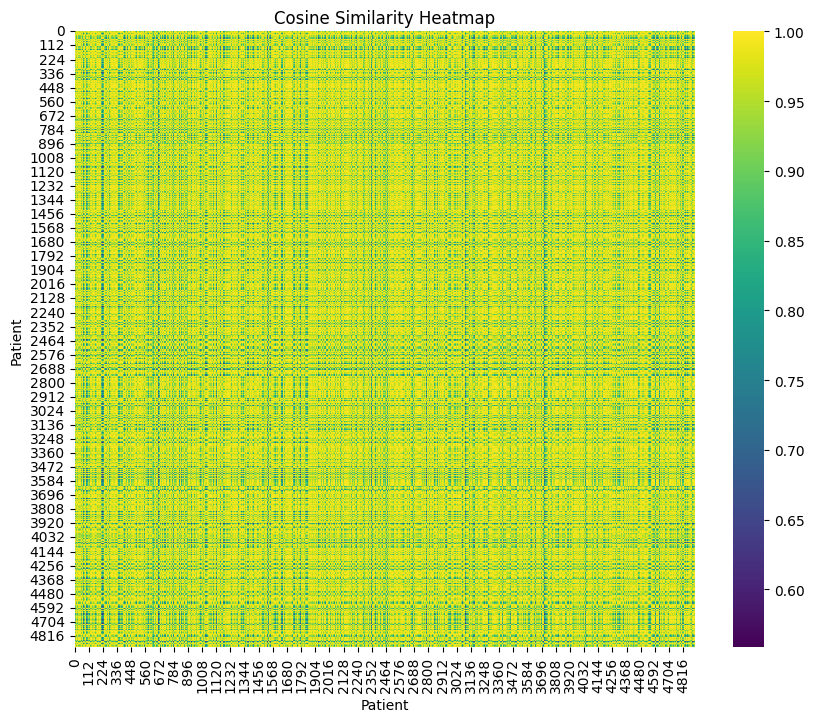

In [26]:
figsize = (10, 8)
plt.figure(figsize=figsize)
sns.heatmap(cosine_sim_matrix, annot=False, cmap='viridis')
plt.title('Cosine Similarity Heatmap')
plt.xlabel('Patient')
plt.ylabel('Patient')
plt.show()

In [27]:
threshold = 0.0 # no filtering used
adjacency_matrix = np.where(cosine_sim_matrix > threshold, cosine_sim_matrix, 0)
graph = nx.from_numpy_array(adjacency_matrix)

In [28]:
# Perform community detection using Louvain
partition = community_louvain.best_partition(graph, random_state=42)

In [29]:
# Add community labels to your DataFrame
numerical_df = numerical_df.assign(community=list(partition.values()))

# Print community distribution
print(numerical_df['community'].value_counts())

community
1    2504
3    2384
4      10
2       9
0       1
Name: count, dtype: int64


In [30]:
community_stats = numerical_df.groupby('community').mean()
print(community_stats)

                 bmi        age  avg_glucose_level
community                                         
0          32.100000  45.000000         106.830000
1          27.238498  30.174121         124.514034
2          28.633333  53.222222         122.570000
3          30.613591  56.185822          85.151674
4          33.670000  31.800000          80.496000


In [31]:
Grouped_df = data_for_grouping.copy()
Grouped_df['community'] =  list(partition.values())
GROUP_2 = Grouped_df[Grouped_df.community.isin([3,4])].drop("community", axis =1)
GROUP_1 = Grouped_df[Grouped_df.community.isin([0,1,2])].drop("community", axis =1)

In [32]:
GROUP_1.describe()

gender_Male  hypertension_1  heart_disease_1  ever_married_Yes  \
count  2514.000000      2514.00000      2514.000000       2514.000000   
mean      0.435959         0.06961         0.036595          0.431583   
std       0.495980         0.25454         0.187803          0.495396   
min       0.000000         0.00000         0.000000          0.000000   
25%       0.000000         0.00000         0.000000          0.000000   
50%       0.000000         0.00000         0.000000          0.000000   
75%       1.000000         0.00000         0.000000          1.000000   
max       1.000000         1.00000         1.000000          1.000000   

       work_type_Never_worked  work_type_Private  work_type_Self-employed  \
count             2514.000000        2514.000000              2514.000000   
mean                 0.008751           0.541766                 0.093079   
std                  0.093155           0.498352                 0.290601   
min                  0.000000           0.000000                 0.000000   
25%                  0.000000           0.000000                 0.000000   
50%                  0.000000           1.000000                 0.000000   
75%                  0.000000           1.000000                 0.000000   
max                  1.000000           1.000000                 1.000000   

       work_type_children  Residence_type_Urban  \
count         2514.000000           2514.000000   
mean             0.266905              0.503580   
std              0.442430              0.500087   
min              0.000000              0.000000   
25%              0.000000              0.000000   
50%              0.000000              1.000000   
75%              1.000000              1.000000   
max              1.000000              1.000000   

       smoking_status_formerly smoked  smoking_status_never smoked  \
count                     2514.000000                  2514.000000   
mean                         0.118934                     0.350040   
std                          0.323775                     0.477077   
min                          0.000000                     0.000000   
25%                          0.000000                     0.000000   
50%                          0.000000                     0.000000   
75%                          0.000000                     1.000000   
max                          1.000000                     1.000000   

       smoking_status_smokes     stroke_1          bmi         age  \
count            2514.000000  2514.000000  2514.000000  2514.00000   
mean                0.127685     0.031026    27.245426    30.26253   
std                 0.333805     0.173423     8.109465    21.64740   
min                 0.000000     0.000000    10.300000     0.00000   
25%                 0.000000     0.000000    21.200000    13.25000   
50%                 0.000000     0.000000    26.100000    26.00000   
75%                 0.000000     0.000000    31.800000    44.00000   
max                 1.000000     1.000000    71.900000    82.00000   

       avg_glucose_level  
count        2514.000000  
mean          124.500040  
std            52.501464  
min            55.120000  
25%            85.202500  
50%           106.350000  
75%           153.292500  
max           271.740000

In [33]:
GROUP_2.describe()

gender_Male  hypertension_1  heart_disease_1  ever_married_Yes  \
count  2394.000000     2394.000000      2394.000000       2394.000000   
mean      0.382206        0.115288         0.063074          0.885129   
std       0.486028        0.319436         0.243147          0.318932   
min       0.000000        0.000000         0.000000          0.000000   
25%       0.000000        0.000000         0.000000          1.000000   
50%       0.000000        0.000000         0.000000          1.000000   
75%       1.000000        0.000000         0.000000          1.000000   
max       1.000000        1.000000         1.000000          1.000000   

       work_type_Never_worked  work_type_Private  work_type_Self-employed  \
count                  2394.0        2394.000000              2394.000000   
mean                      0.0           0.604845                 0.225982   
std                       0.0           0.488986                 0.418315   
min                       0.0           0.000000                 0.000000   
25%                       0.0           0.000000                 0.000000   
50%                       0.0           1.000000                 0.000000   
75%                       0.0           1.000000                 0.000000   
max                       0.0           1.000000                 1.000000   

       work_type_children  Residence_type_Urban  \
count              2394.0           2394.000000   
mean                  0.0              0.511278   
std                   0.0              0.499977   
min                   0.0              0.000000   
25%                   0.0              0.000000   
50%                   0.0              1.000000   
75%                   0.0              1.000000   
max                   0.0              1.000000   

       smoking_status_formerly smoked  smoking_status_never smoked  \
count                     2394.000000                  2394.000000   
mean                         0.224311                     0.406015   
std                          0.417215                     0.491190   
min                          0.000000                     0.000000   
25%                          0.000000                     0.000000   
50%                          0.000000                     0.000000   
75%                          0.000000                     1.000000   
max                          1.000000                     1.000000   

       smoking_status_smokes     stroke_1          bmi         age  \
count            2394.000000  2394.000000  2394.000000  2394.00000   
mean                0.173768     0.054720    30.626358    56.08396   
std                 0.378989     0.227481     7.182009    14.54098   
min                 0.000000     0.000000    11.300000    17.00000   
25%                 0.000000     0.000000    26.000000    45.00000   
50%                 0.000000     0.000000    29.500000    55.00000   
75%                 0.000000     0.000000    34.000000    67.00000   
max                 1.000000     1.000000    97.600000    82.00000   

       avg_glucose_level  
count        2394.000000  
mean           85.132226  
std            18.927130  
min            55.220000  
25%            71.237500  
50%            82.820000  
75%            95.880000  
max           181.230000

## Distances withing groups

In [34]:
scaler   = QuantileTransformer(output_distribution='normal', random_state=0)
scaler_2 = QuantileTransformer(output_distribution='normal', random_state=0)

data_scaled_1 = scaler.fit_transform(GROUP_1)
data_scaled_2 = scaler_2.fit_transform(GROUP_2)

In [35]:
# Calculate the covariance matrix and its inverse
cov_matrix = np.cov(data_scaled_1, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Calculate the mean of the data
mean_vector = np.mean(data_scaled_1, axis=0)

md = mahalanobis_distance(data_scaled_1, mean_vector, inv_cov_matrix)
GROUP_1['Mahalanobis_Distance'] = md

In [36]:
# Degrees of freedom is the number of variables
df_variables = data_scaled_1.shape[1]

# Set significance level (e.g., 0.01 for 99% confidence)
alpha = 0.01
threshold = chi2.ppf((1 - alpha), df_variables)
GROUP_1['Mah_Outlier'] = GROUP_1['Mahalanobis_Distance'] > threshold

In [37]:
GROUP_1.Mah_Outlier.value_counts()

Mah_Outlier
False    2270
True      244
Name: count, dtype: int64

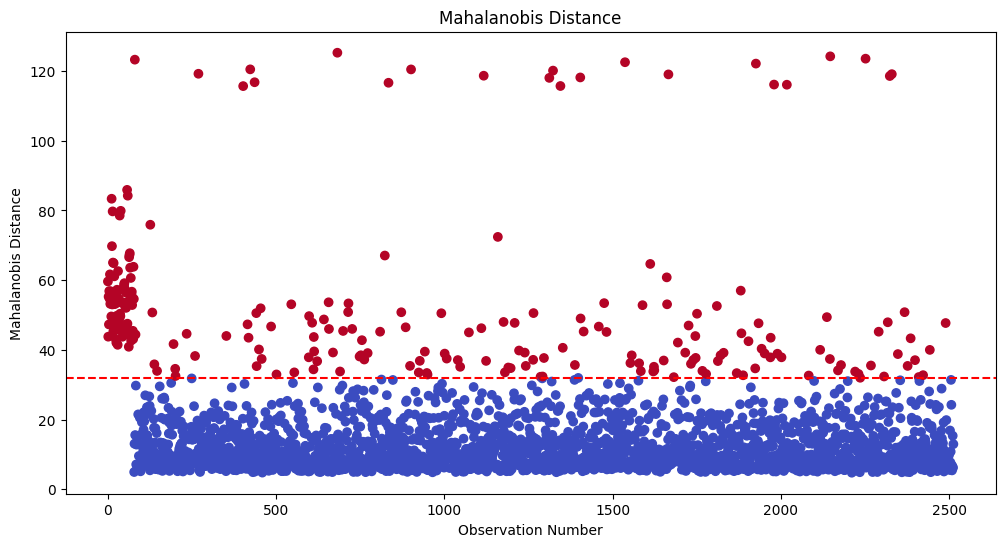

In [38]:
plt.figure(figsize=(12, 6))
plt.title('Mahalanobis Distance')
plt.xlabel('Observation Number')
plt.ylabel('Mahalanobis Distance')
# Scatter plot of Mahalanobis distances
plt.scatter(range(len(GROUP_1)), GROUP_1['Mahalanobis_Distance'], c=GROUP_1['Mah_Outlier'], cmap='coolwarm')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.show()

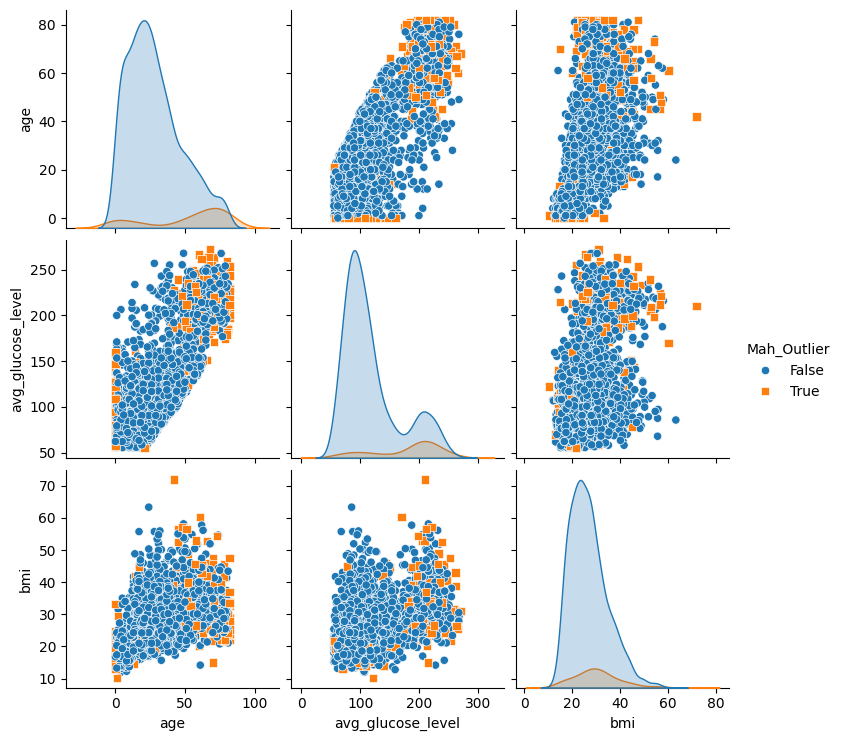

In [39]:
# Add the 'Outlier' column back to the standardized data for plotting
data_subset_1 = pd.DataFrame(GROUP_1, columns=numerical_cols)
data_subset_1['Mah_Outlier'] = GROUP_1['Mah_Outlier'].values
sns.pairplot(data_subset_1, hue='Mah_Outlier', diag_kind='kde', markers=["o", "s"])
plt.show()

In [40]:
lof   = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
lof_2 = LocalOutlierFactor(n_neighbors=20, contamination=0.02)

GROUP_1['LOF_Score'] = lof.fit_predict(data_scaled_1)
GROUP_2['LOF_Score'] = lof_2.fit_predict(data_scaled_2)

# LOF_Score: -1 indicates outlier, 1 indicates inlier
GROUP_1['LOF_Outlier'] = GROUP_1['LOF_Score'] == -1
GROUP_2['LOF_Outlier'] = GROUP_2['LOF_Score'] == -1

GROUP_1.LOF_Outlier.value_counts()
GROUP_2.LOF_Outlier.value_counts()

LOF_Outlier
False    2346
True       48
Name: count, dtype: int64

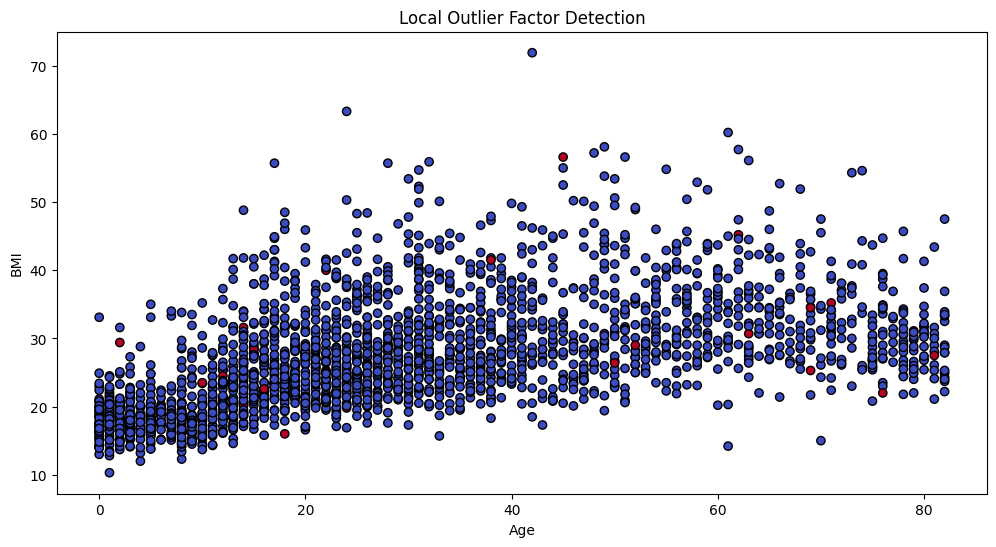

In [41]:
plt.figure(figsize=(12, 6))
plt.scatter(GROUP_1['age'], GROUP_1['bmi'], c=GROUP_1['LOF_Outlier'], cmap='coolwarm', edgecolor='k')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.title('Local Outlier Factor Detection')
plt.show()

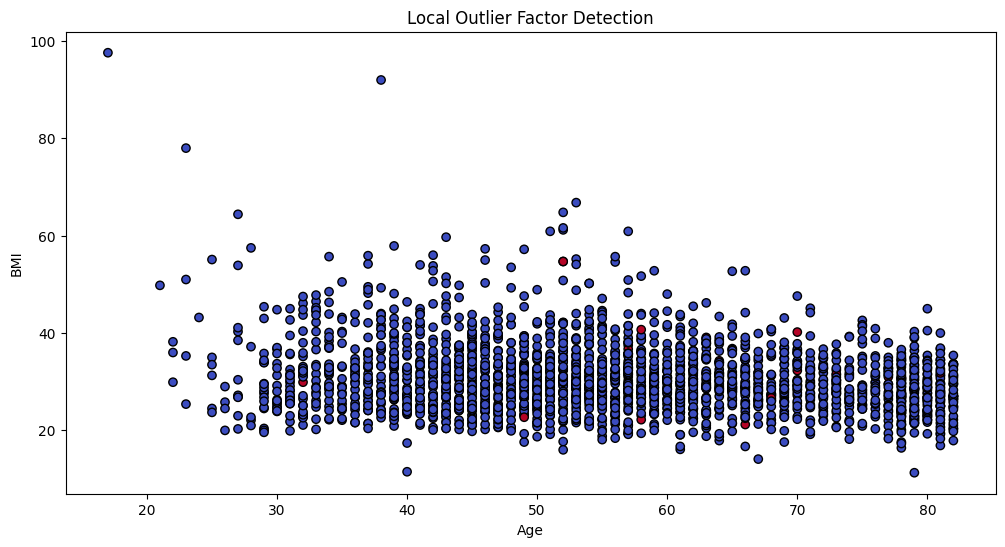

In [42]:
plt.figure(figsize=(12, 6))
plt.scatter(GROUP_2['age'], GROUP_2['bmi'], c=GROUP_2['LOF_Outlier'], cmap='coolwarm', edgecolor='k')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.title('Local Outlier Factor Detection')
plt.show()

In [43]:
iso_forest = IsolationForest(contamination=0.03, random_state=42)
iso_forest_2 = IsolationForest(contamination=0.03, random_state=42)

iso_forest.fit(data_scaled_1)
iso_forest_2.fit(data_scaled_2)

GROUP_1['IF_Score'] = iso_forest.decision_function(data_scaled_1)
GROUP_1['IF_Outlier'] = iso_forest.predict(data_scaled_1) == -1

GROUP_2['IF_Score'] = iso_forest_2.decision_function(data_scaled_2)
GROUP_2['IF_Outlier'] = iso_forest_2.predict(data_scaled_2) == -1
GROUP_1.IF_Outlier.value_counts()

IF_Outlier
False    2438
True       76
Name: count, dtype: int64

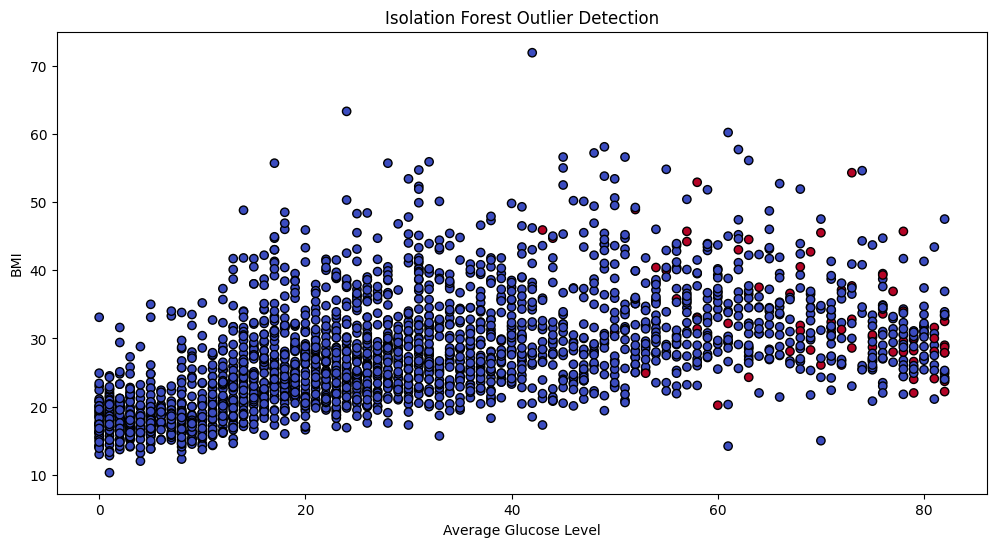

In [44]:
plt.figure(figsize=(12, 6))
plt.scatter(GROUP_1['age'], GROUP_1['bmi'], c=GROUP_1['IF_Outlier'], cmap='coolwarm', edgecolor='k')
plt.xlabel('Average Glucose Level')
plt.ylabel('BMI')
plt.title('Isolation Forest Outlier Detection')
plt.show()

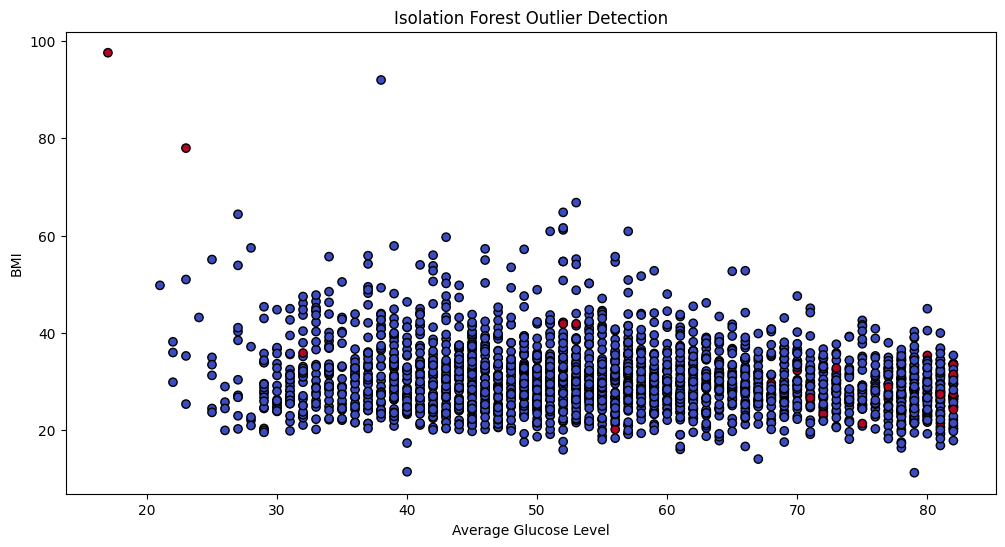

In [45]:
plt.figure(figsize=(12, 6))
plt.scatter(GROUP_2['age'], GROUP_2['bmi'], c=GROUP_2['IF_Outlier'], cmap='coolwarm', edgecolor='k')
plt.xlabel('Average Glucose Level')
plt.ylabel('BMI')
plt.title('Isolation Forest Outlier Detection')
plt.show()

In [46]:
outlier_methods = ['Mah_Outlier', 'LOF_Outlier', 'IF_Outlier']
outlier_flags = GROUP_1[outlier_methods]
outlier_flags_2 = GROUP_2[['LOF_Outlier', 'IF_Outlier']]

GROUP_1['Outlier_Score'] = outlier_flags.sum(axis=1)
GROUP_2['Outlier_Score'] = outlier_flags_2.sum(axis=1)

GROUP_1['Multi_Method_Outlier'] = GROUP_1['Outlier_Score'] >= 2  # Adjust threshold as needed
GROUP_2['Multi_Method_Outlier'] = GROUP_2['Outlier_Score'] == 2  # Adjust threshold as needed

num_multi_outliers = GROUP_1['Multi_Method_Outlier'].sum()
num_multi_outliers_2 = GROUP_2['Multi_Method_Outlier'].sum()

print(f"Number of observations flagged by multiple methods for group 1: {num_multi_outliers}")
print(f"Number of observations flagged by multiple methods for Group 2: {num_multi_outliers_2}")

multi_outliers = GROUP_1[GROUP_1['Multi_Method_Outlier']]
multi_outliers_2 = GROUP_2[GROUP_2['Multi_Method_Outlier']]

Number of observations flagged by multiple methods for group 1: 93
Number of observations flagged by multiple methods for Group 2: 1


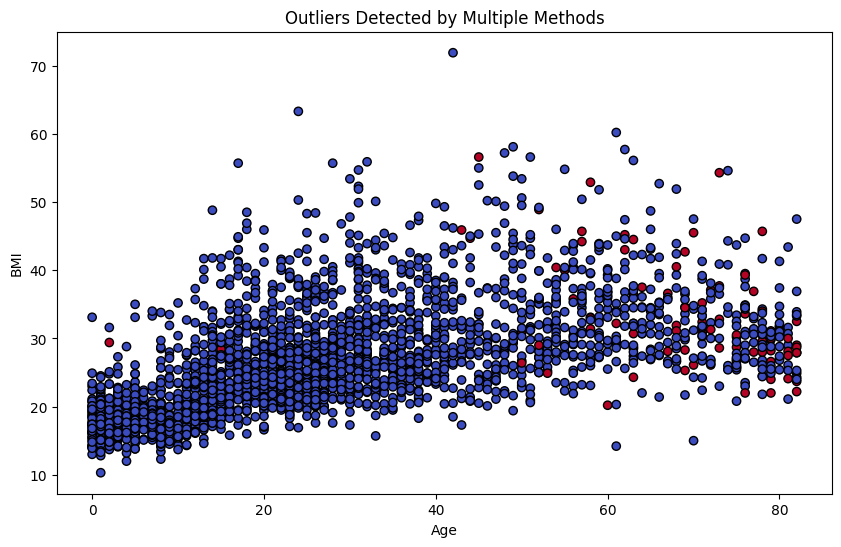

In [47]:
# Plotting with multi-method outliers highlighted
plt.figure(figsize=(10, 6))
plt.scatter(GROUP_1['age'], GROUP_1['bmi'], c=GROUP_1['Multi_Method_Outlier'], cmap='coolwarm', edgecolor='k')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.title('Outliers Detected by Multiple Methods')
plt.show()

In [48]:
# Count multi-method outliers with stroke
multi_outliers_with_stroke = GROUP_1[(GROUP_1['Multi_Method_Outlier']) & (GROUP_1['stroke_1'] == 1)]
num_multi_outliers_with_stroke = len(multi_outliers_with_stroke)
print(f"Number of multi-method outliers with stroke: {num_multi_outliers_with_stroke}")

# Compare to total outliers and strokes
total_multi_outliers = GROUP_1['Multi_Method_Outlier'].sum()
total_stroke_cases = GROUP_1['stroke_1'].sum()
print(f"Total multi-method outliers: {total_multi_outliers}")
print(f"Total stroke cases: {total_stroke_cases}")

Number of multi-method outliers with stroke: 49
Total multi-method outliers: 93
Total stroke cases: 78


## Classification

### Group-based analysis

#### Group 1


             Fit and Predict Summary              

Evaluation Metrics:
--------------------------------------------------
╒═══════════════════╤═════════╕
│ Metric            │   Value │
╞═══════════════════╪═════════╡
│ Class 0           │    0.99 │
├───────────────────┼─────────┤
│ Class 1           │    1    │
├───────────────────┼─────────┤
│ Balanced Accuracy │    1    │
╘═══════════════════╧═════════╛
+ Accuracy for top 10 percent predictions for Healthy: 100.00, Stroke: 79.31
+ Accuracy for top 20 percent predictions for Healthy: 100.00, Stroke: 79.31
+ Accuracy for top 30 percent predictions for Healthy: 100.00, Stroke: 79.31
+ Accuracy for top 40 percent predictions for Healthy: 100.00, Stroke: 79.31
+ Accuracy for top 50 percent predictions for Healthy: 100.00, Stroke: 79.31
+ Accuracy for top 60 percent predictions for Healthy: 100.00, Stroke: 79.31
+ Accuracy for top 70 percent predictions for Healthy: 100.00, Stroke: 79.31
+ Accuracy for top 80 percent predictions for Hea

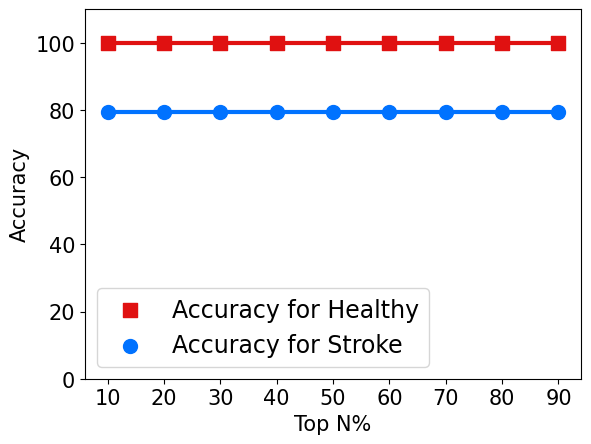


Permutation Test Results:
+----------+----------------------+-----------+
| Metric   |   Observed Statistic |   p-value |
+==========+======================+===========+
| accuracy |               0.9921 |         0 |
+----------+----------------------+-----------+
| log_loss |              -0.0207 |         0 |
+----------+----------------------+-----------+
| auc      |               0.9992 |         0 |
+----------+----------------------+-----------+


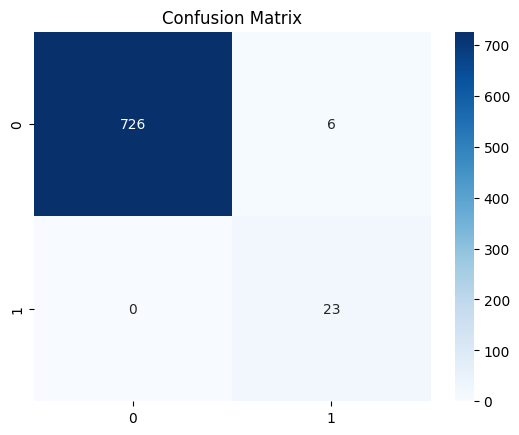

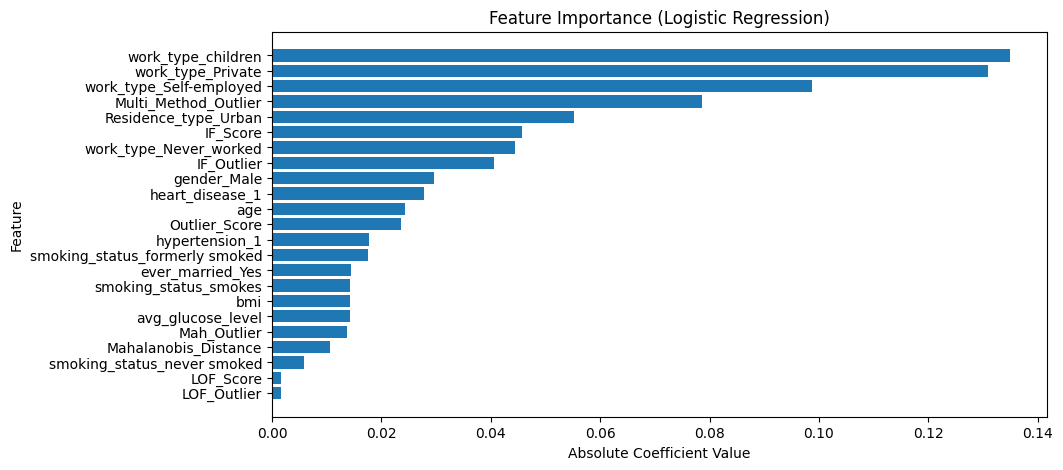

In [49]:
model = LogisticRegression(random_state=42)
scaler = None
sampling = "SMOTE"
fit_and_predict(model, GROUP_1, scaling = StandardScaler(), plots = True, sampling= sampling, topNValues = topNValues)

In [50]:
fit_and_predict(model, GROUP_1, scaling = StandardScaler(), plots = False, sampling= sampling, topNValues = topNValues, ensemble=None, cv_folds=5, use_cv=True)


             Fit and Predict Summary              
Cross-validated balanced accuracy: 0.967 ± 0.028


#### Group 2


             Fit and Predict Summary              

Evaluation Metrics:
--------------------------------------------------
╒═══════════════════╤═════════╕
│ Metric            │   Value │
╞═══════════════════╪═════════╡
│ Class 0           │    0.98 │
├───────────────────┼─────────┤
│ Class 1           │    0.97 │
├───────────────────┼─────────┤
│ Balanced Accuracy │    0.98 │
╘═══════════════════╧═════════╛
+ Accuracy for top 10 percent predictions for Healthy: 100.00, Stroke: 77.55
+ Accuracy for top 20 percent predictions for Healthy: 100.00, Stroke: 77.55
+ Accuracy for top 30 percent predictions for Healthy: 100.00, Stroke: 77.55
+ Accuracy for top 40 percent predictions for Healthy: 100.00, Stroke: 77.55
+ Accuracy for top 50 percent predictions for Healthy: 100.00, Stroke: 77.55
+ Accuracy for top 60 percent predictions for Healthy: 100.00, Stroke: 77.55
+ Accuracy for top 70 percent predictions for Healthy: 100.00, Stroke: 77.55
+ Accuracy for top 80 percent predictions for Hea

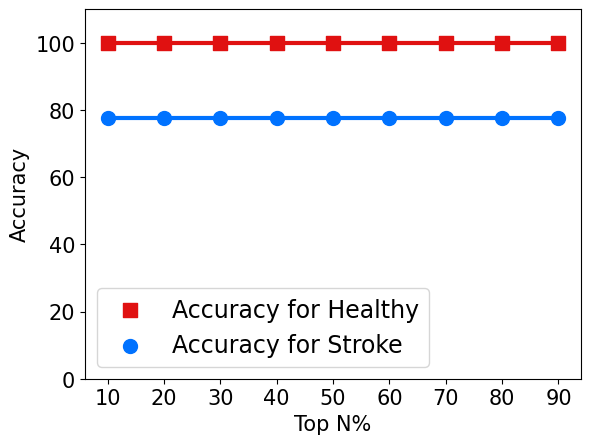


Permutation Test Results:
+----------+----------------------+-----------+
| Metric   |   Observed Statistic |   p-value |
+==========+======================+===========+
| accuracy |               0.9833 |         0 |
+----------+----------------------+-----------+
| log_loss |              -0.0595 |         0 |
+----------+----------------------+-----------+
| auc      |               0.9956 |         0 |
+----------+----------------------+-----------+


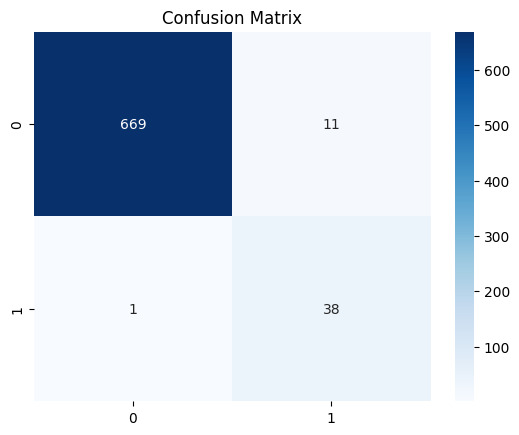

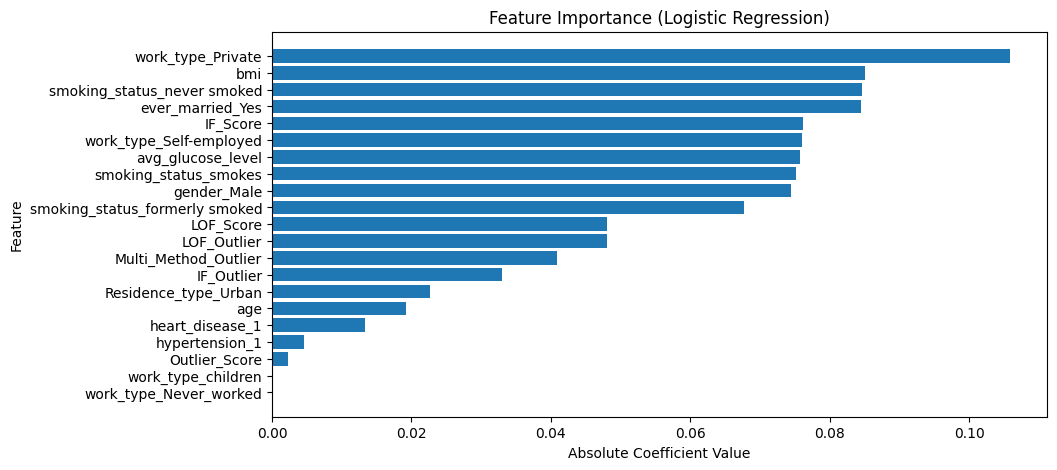

In [51]:
model = LogisticRegression(random_state=42)
sampling = "ADASYN"
fit_and_predict(model, GROUP_2, scaling = StandardScaler(), plots = True, sampling= sampling, topNValues = topNValues, ensemble=None)

In [53]:
fit_and_predict(model, GROUP_2, scaling = StandardScaler(), plots = False, sampling= sampling, topNValues = topNValues, ensemble=None, cv_folds=5, use_cv=True)


             Fit and Predict Summary              
Cross-validated balanced accuracy: 0.918 ± 0.021


### No Grouping nor feature engineering -- original data


             Fit and Predict Summary              

Evaluation Metrics:
--------------------------------------------------
╒═══════════════════╤═════════╕
│ Metric            │   Value │
╞═══════════════════╪═════════╡
│ Class 0           │    0.77 │
├───────────────────┼─────────┤
│ Class 1           │    0.71 │
├───────────────────┼─────────┤
│ Balanced Accuracy │    0.74 │
╘═══════════════════╧═════════╛

Permutation Test Results:
+----------+----------------------+-----------+
| Metric   |   Observed Statistic |   p-value |
+==========+======================+===========+
| accuracy |               0.7658 |         0 |
+----------+----------------------+-----------+
| log_loss |              -0.4698 |         0 |
+----------+----------------------+-----------+
| auc      |               0.8207 |         0 |
+----------+----------------------+-----------+


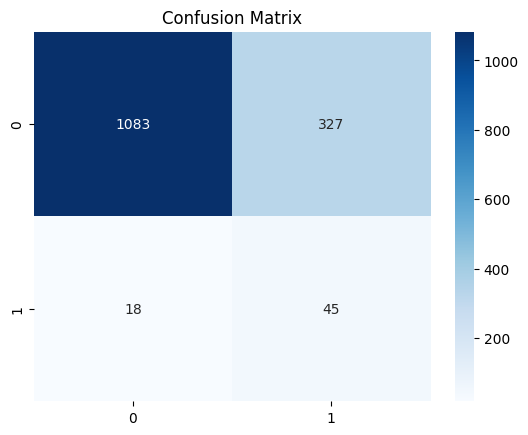

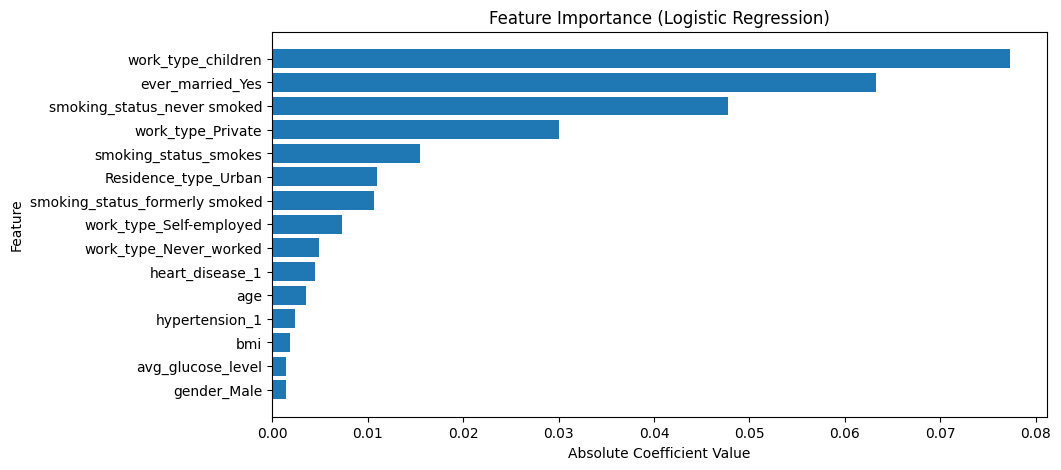

In [54]:
model = LogisticRegression(random_state=42)
sampling = "SMOTE"
fit_and_predict(model, data_for_grouping, scaling = StandardScaler(), plots = False, sampling= sampling, topNValues = topNValues, ensemble=None)


             Fit and Predict Summary              

Evaluation Metrics:
--------------------------------------------------
╒═══════════════════╤═════════╕
│ Metric            │   Value │
╞═══════════════════╪═════════╡
│ Class 0           │    0.38 │
├───────────────────┼─────────┤
│ Class 1           │    0.98 │
├───────────────────┼─────────┤
│ Balanced Accuracy │    0.68 │
╘═══════════════════╧═════════╛

Permutation Test Results:
+----------+----------------------+-----------+
| Metric   |   Observed Statistic |   p-value |
+==========+======================+===========+
| accuracy |               0.406  |         0 |
+----------+----------------------+-----------+
| log_loss |              -2.3315 |         0 |
+----------+----------------------+-----------+
| auc      |               0.8149 |         0 |
+----------+----------------------+-----------+


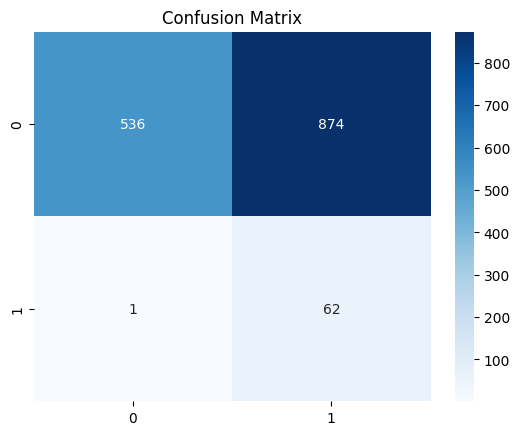

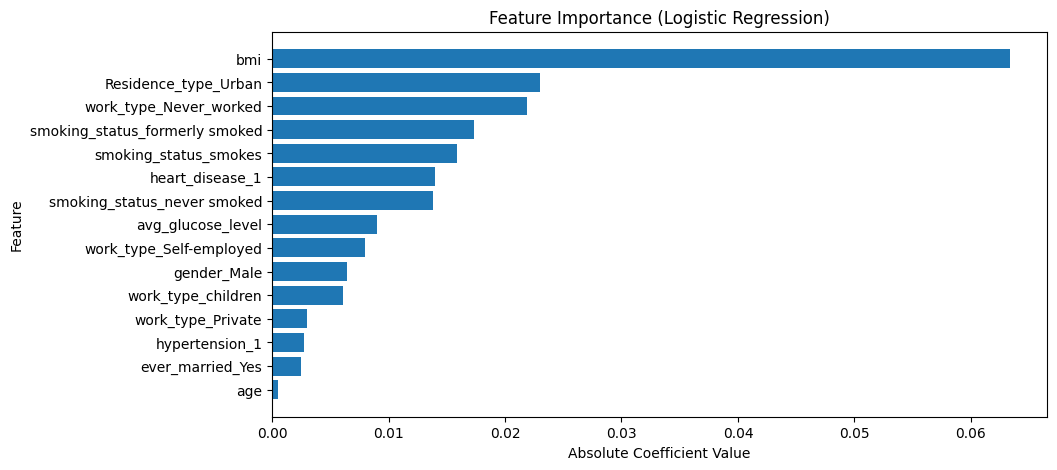

In [55]:
custom_cw = class_weight={0: 1, 1: 70}
model = LogisticRegression(class_weight=custom_cw, random_state=42,max_iter=1000)
scaler = StandardScaler()
sampling = "ADASYN"
fit_and_predict(model, data_for_grouping, scaling = scaler, plots = False, sampling= sampling, topNValues = topNValues, ensemble=None)

In [56]:
fit_and_predict(model, data_for_grouping, scaling = StandardScaler(), plots = False, sampling= sampling, topNValues = topNValues, ensemble=None, cv_folds=5, use_cv=True)


             Fit and Predict Summary              
Cross-validated balanced accuracy: 0.742 ± 0.017


## Logistic GAM (explored)

In [58]:
numeric_features = ['bmi', 'age', 'avg_glucose_level']

### Group 1

ROC AUC Score: 0.9505226894749347
Log Loss: 0.0764477319654121


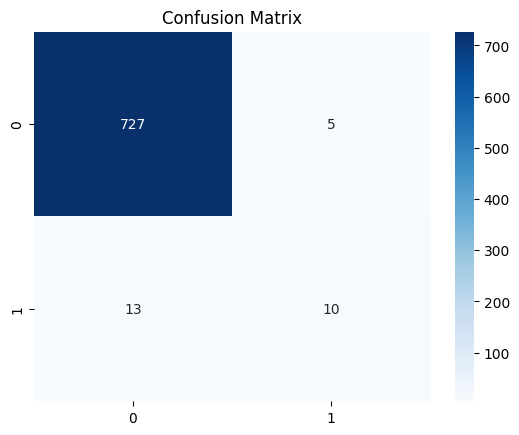

In [63]:
model_gam = LogisticGAM(f(0) +f(1) +f(2) +f(3) +f(4) +f(5) + f(6) +f(7) +f(8) +f(9) +f(10) +f(11) +s(12, n_splines=10) + s(13, n_splines=10) +s(14, n_splines=10) +f(22))

hey = GROUP_1*1
scaler = StandardScaler()
X = hey.drop(columns=['stroke_1'])
y = hey['stroke_1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)
numeric_features = ['bmi', 'age', 'avg_glucose_level']
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.fit_transform(X_test[numeric_features])


model_gam.fit(X_train, y_train)
y_pred = model_gam.predict(X_test)

y_pred_probs = model_gam.predict_proba(X_test)
conf_matrix = plot_confusion_matrix(y_test, y_pred)
conf_matrix

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_probs))
print("Log Loss:", log_loss(y_test, y_pred_probs))

In [64]:
lam_values = np.logspace(-3, 3, 7)  # 7 values from 10^-3 to 10^3
gam = LogisticGAM(f(0) +f(1) +f(2) +f(3) +f(4) +f(5) + f(6) +f(7) +f(8) +f(9) +f(10) +f(11) +s(12, n_splines=5) + s(13, n_splines=5) +s(14, n_splines=5) +f(22))
best_gam = gam.gridsearch(X_train.values, y_train, lam=lam_values)
print(best_gam.summary())

100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     15.9105
Link Function:                        LogitLink Log Likelihood:                                   -88.4675
Number of Samples:                         1759 AIC:                                              208.7559
                                                AICc:                                             209.1038
                                                UBRE:                                               2.1259
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.6385
Feature Function                  Lam

/var/folders/3b/1dzvglj17w110wnj0rq1ngkh0000gn/T/ipykernel_1417/3693444541.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(best_gam.summary())


ROC AUC Score: 0.9419695889760038
Log Loss: 0.08038423610489502


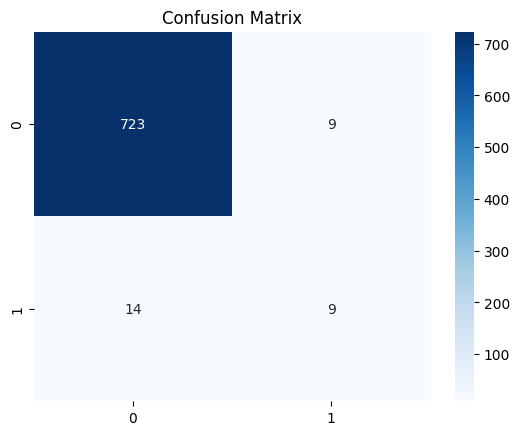

In [65]:
# keep s13, f22, f6, f3, f2

model_gam = LogisticGAM(f(1)+f(2)+ f(3)+s(13, n_splines=10) +f(22))
model_gam.fit(X_train, y_train)
y_pred = model_gam.predict(X_test)

y_pred_probs = model_gam.predict_proba(X_test)
conf_matrix = plot_confusion_matrix(y_test, y_pred)
conf_matrix

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_probs))
print("Log Loss:", log_loss(y_test, y_pred_probs))

### Group 2

ROC AUC Score: 0.6683634992458521
Log Loss: 0.20914310159657315


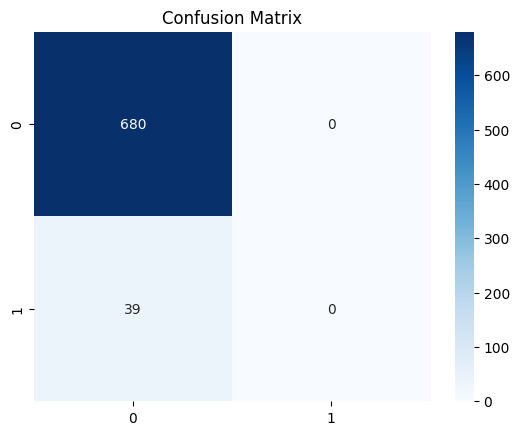

In [66]:
model_gam = LogisticGAM(f(0) +f(1) +f(2) +f(3) +f(4) +f(5) + f(6) +f(7) +f(8) +f(9) +f(10) +f(11) +s(12, n_splines=10) + s(13, n_splines=10) +s(14, n_splines=10) +f(20))
hey = GROUP_2*1
scaler = StandardScaler()
X = hey.drop(columns=['stroke_1'])
y = hey['stroke_1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.fit_transform(X_test[numeric_features])

model_gam.fit(X_train, y_train)
y_pred = model_gam.predict(X_test)

y_pred_probs = model_gam.predict_proba(X_test)
conf_matrix = plot_confusion_matrix(y_test, y_pred)
conf_matrix

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_probs))
print("Log Loss:", log_loss(y_test, y_pred_probs))

In [67]:
lam_values = np.logspace(-3, 3, 7)  # 7 values from 10^-3 to 10^3
gam = LogisticGAM(f(0) +f(1) +f(2) +f(3) +f(4) +f(5) + f(6) +f(7) +f(8) +f(9) +f(10) +f(11) +s(12, n_splines=10) + s(13, n_splines=10) +s(14, n_splines=10) +f(20))
best_gam = gam.gridsearch(X_train.values, y_train, lam=lam_values)
print(best_gam.summary())


100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      4.3357
Link Function:                        LogitLink Log Likelihood:                                  -314.3066
Number of Samples:                         1675 AIC:                                              637.2846
                                                AICc:                                             637.3252
                                                UBRE:                                               2.3825
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1181
Feature Function                  Lam

/var/folders/3b/1dzvglj17w110wnj0rq1ngkh0000gn/T/ipykernel_1417/2327313024.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(best_gam.summary())


ROC AUC Score: 0.6831447963800905
Log Loss: 0.20445880683245488


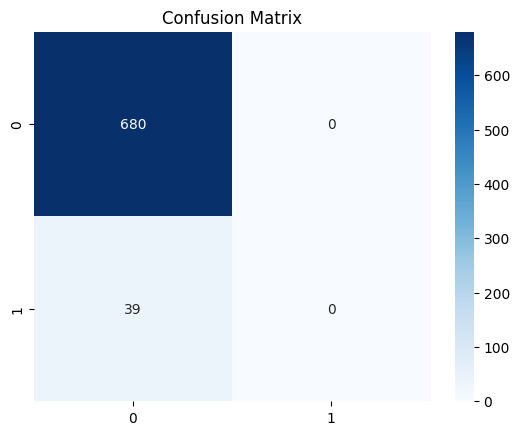

In [68]:
# keep s13 and f20 and f1

model_gam = LogisticGAM(f(1)+ s(13, n_splines=10) +f(20))
model_gam.fit(X_train, y_train)
y_pred = model_gam.predict(X_test)
y_pred_probs = model_gam.predict_proba(X_test)
conf_matrix = plot_confusion_matrix(y_test, y_pred)
conf_matrix
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_probs))
print("Log Loss:", log_loss(y_test, y_pred_probs))